In [1]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

MAX_SEQ_LENGTH = 40
NUM_FEATURES = 1280

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 9537
Total videos for testing: 3783


,video_name,tag
4744,v_Knitting_g12_c03.avi,Knitting
8561,v_TaiChi_g13_c04.avi,TaiChi
3752,v_HeadMassage_g24_c01.avi,HeadMassage
7197,v_Rowing_g15_c06.avi,Rowing
56,v_ApplyEyeMakeup_g18_c01.avi,ApplyEyeMakeup
4213,v_IceDancing_g19_c07.avi,IceDancing
6574,v_PommelHorse_g18_c03.avi,PommelHorse
270,v_Archery_g23_c04.avi,Archery
7054,v_RockClimbingIndoor_g24_c06.avi,RockClimbingIndoor
2809,v_FloorGymnastics_g11_c01.avi,FloorGymnastics


In [4]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


In [8]:

def build_feature_extractor():
    feature_extractor = keras.applications.EfficientNetB0(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.efficientnet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [9]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress', 'Biking', 'Billiards', 'BlowDryHair', 'BlowingCandles', 'BodyWeightSquats', 'Bowling', 'BoxingPunchingBag', 'BoxingSpeedBag', 'BreastStroke', 'BrushingTeeth', 'CleanAndJerk', 'CliffDiving', 'CricketBowling', 'CricketShot', 'CuttingInKitchen', 'Diving', 'Drumming', 'Fencing', 'FieldHockeyPenalty', 'FloorGymnastics', 'FrisbeeCatch', 'FrontCrawl', 'GolfSwing', 'Haircut', 'HammerThrow', 'Hammering', 'HandstandPushups', 'HandstandWalking', 'HeadMassage', 'HighJump', 'HorseRace', 'HorseRiding', 'HulaHoop', 'IceDancing', 'JavelinThrow', 'JugglingBalls', 'JumpRope', 'JumpingJack', 'Kayaking', 'Knitting', 'LongJump', 'Lunges', 'MilitaryParade', 'Mixing', 'MoppingFloor', 'Nunchucks', 'ParallelBars', 'PizzaTossing', 'PlayingCello', 'PlayingDaf', 'PlayingDhol', 'PlayingFlute', 'PlayingGuitar', 'PlayingPiano', 'PlayingSitar', 'PlayingTabla', 'P

In [12]:
from tqdm import tqdm

def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in tqdm(enumerate(video_paths)):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


# train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

# print(f"Frame features in train set: {train_data[0].shape}")
# print(f"Frame masks in train set: {train_data[1].shape}")

3783it [2:19:22,  2.21s/it]


In [14]:
train_data, train_labels = prepare_all_videos(train_df, "train")

9537it [6:02:32,  2.28s/it]


In [ ]:
# Utility for our sequence model.
# Bidirectional

def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.Bidirectional(keras.layers.LSTM(2048, return_sequences=False,dropout=0.5))(#16, 512
        frame_features_input, mask=mask_input
    )
#     x = keras.layers.LSTM(2048)(x)#8, 256
#     x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(1024)(x)#8, 256
    x = keras.layers.LeakyReLU()(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    print(seq_model.summary())
    
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.2,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

In [ ]:
#40.13% LSTM(2048,dropout=0.1)
#46.47% LSTM(2048,dropout=0.5)
#43.96% LSTM(4096,dropout=0.5)

In [ ]:
class_vocab = label_processor.get_vocabulary()

frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

# Refer to the following tutorial to understand the significance of using `mask`:
# https://keras.io/api/layers/recurrent_layers/gru/
x = keras.layers.LSTM(2048, return_sequences=True,dropout=0.1)(#16, 512
    frame_features_input, mask=mask_input
)
#     x = keras.layers.LSTM(2048)(x)#8, 256
#     x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(1024, activation="relu")(x)#8, 256
output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

rnn_model = keras.Model([frame_features_input, mask_input], output)

rnn_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

print(rnn_model.summary())

In [ ]:
class_vocab = label_processor.get_vocabulary()

frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

# Refer to the following tutorial to understand the significance of using `mask`:
# https://keras.io/api/layers/recurrent_layers/gru/
x = keras.layers.LSTM(2048, return_sequences=False,dropout=0.1)(#16, 512
    frame_features_input, mask=mask_input
)
# x = keras.layers.LSTM(2048)(x)#8, 256
#     x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(1024, activation="relu")(x)#8, 256
output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

rnn_model = keras.Model([frame_features_input, mask_input], output)

rnn_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

print(rnn_model.summary())

In [ ]:

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [ ]:
ls -l

In [ ]:
import numpy as np
import tensorflow as tf 

np.save('Inception_CNNRNN_train_data.npy', train_data)    # .npy extension is added if not given
# np.save('Inception_CNNRNN_test_data.npy', test_data[0])    # .npy extension is added if not given
# np.save('Inception_CNNRNN_train_labels.npy', train_data[1])    # .npy extension is added if not given
# np.save('Inception_CNNRNN_test_labels.npy', test_labels)    # .npy extension is added if not given

In [ ]:
print(train_data[0].shape)
print(train_data[1].shape)

In [ ]:
print(train_data.type)

In [15]:
import pickle

with open('EffB0_CNNRNN_train_40.pickle', 'wb') as f:
    pickle.dump(train_data, f)

In [13]:
import pickle

with open('EffB0_CNNRNN_test_40.pickle', 'wb') as f:
    pickle.dump(test_data, f)

In [ ]:
import numpy as np
import tensorflow as tf 

# np.save('densenet_train_data.npy', train_data)    # .npy extension is added if not given
# np.save('densenet_test_data.npy', test_data)    # .npy extension is added if not given
np.save('CNNRNN_train_labels.npy', train_labels)    # .npy extension is added if not given
np.save('CNNRNN_test_labels.npy', test_labels)    # .npy extension is added if not given

In [ ]:
ls -l

In [ ]:
mv Inception_CNNRNN_20.pickle Inception_CNNRNN_train_20.pickle

In [4]:
import numpy as np
import tensorflow as tf 
import pickle

with open('EffB0_CNNRNN_train_40.pickle', 'rb') as f:
     d_train_data = pickle.load(f)
with open('EffB0_CNNRNN_test_40.pickle', 'rb') as f:
     d_test_data = pickle.load(f)
        
# d_train_data = np.load('densenet_train_data.npy')
# d_test_data = np.load('densenet_test_data.npy')
d_train_labels = np.load('CNNRNN_train_labels.npy')
d_test_labels = np.load('CNNRNN_test_labels.npy')

In [5]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
# print(label_processor.get_vocabulary())

def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.LSTM(2048, return_sequences=False,dropout=0.5)(#16, 512
        frame_features_input, mask=mask_input
    )    
#     x = keras.layers.Bidirectional(keras.layers.LSTM(2048, return_sequences=False,dropout=0.5),merge_mode='concat')(#16, 512
#         frame_features_input, mask=mask_input
#     )
#     x = keras.layers.LSTM(2048)(x)#8, 256
#     x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(1024)(x)#8, 256
    x = keras.layers.GaussianNoise(0.4)(x)
    x = keras.layers.LeakyReLU(0.1)(x)    
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

#     rnn_model.compile(
#         loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
#     )
    return rnn_model

# Utility for running experiments.
def d_run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    print(seq_model.summary())
    
    optimizer = keras.optimizers.SGD(lr=1e-3)
#     optimizer = keras.optimizers.Adadelta()
    
    seq_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )    
    
    history = seq_model.fit(
        [d_train_data[0], d_train_data[1]],
        d_train_labels,
#         validation_split=0.2,
        validation_data=([d_test_data[0], d_test_data[1]],
        d_test_labels),
        epochs=100,
#         epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([d_test_data[0], d_test_data[1]], d_test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


d_run_experiment()

2022-07-05 23:05:31.899660: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-05 23:05:32.451403: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 1280)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 2048)         27271168    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1024)         2098176     ['lstm[0][0]']               

/home/bribeiro/miniconda3/envs/ar/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
2022-07-05 23:05:40.398387: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1953177600 exceeds 10% of free system memory.
2022-07-05 23:05:42.015886: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1953177600 exceeds 10% of free system memory.


Epoch 1/100


2022-07-05 23:05:46.035281: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


298/299 [============================>.] - ETA: 0s - loss: 4.6480 - accuracy: 0.0149
Epoch 1: val_loss improved from inf to 4.51185, saving model to /tmp/video_classifier
299/299 [==============================] - 22s 61ms/step - loss: 4.6480 - accuracy: 0.0149 - val_loss: 4.5118 - val_accuracy: 0.0537
Epoch 2/100
299/299 [==============================] - ETA: 0s - loss: 4.5216 - accuracy: 0.0282
Epoch 2: val_loss improved from 4.51185 to 4.39449, saving model to /tmp/video_classifier
299/299 [==============================] - 17s 55ms/step - loss: 4.5216 - accuracy: 0.0282 - val_loss: 4.3945 - val_accuracy: 0.1647
Epoch 3/100
298/299 [============================>.] - ETA: 0s - loss: 4.4032 - accuracy: 0.0536
Epoch 3: val_loss improved from 4.39449 to 4.27442, saving model to /tmp/video_classifier
299/299 [==============================] - 17s 56ms/step - loss: 4.4032 - accuracy: 0.0536 - val_loss: 4.2744 - val_accuracy: 0.2728
Epoch 4/100
299/299 [==============================] - E

299/299 [==============================] - 16s 55ms/step - loss: 0.8664 - accuracy: 0.8120 - val_loss: 1.1814 - val_accuracy: 0.7008
Epoch 27/100
299/299 [==============================] - ETA: 0s - loss: 0.7873 - accuracy: 0.8309
Epoch 27: val_loss improved from 1.18138 to 1.17735, saving model to /tmp/video_classifier
299/299 [==============================] - 17s 55ms/step - loss: 0.7873 - accuracy: 0.8309 - val_loss: 1.1774 - val_accuracy: 0.6883
Epoch 28/100
299/299 [==============================] - ETA: 0s - loss: 0.7150 - accuracy: 0.8444
Epoch 28: val_loss improved from 1.17735 to 1.10425, saving model to /tmp/video_classifier
299/299 [==============================] - 17s 56ms/step - loss: 0.7150 - accuracy: 0.8444 - val_loss: 1.1042 - val_accuracy: 0.7132
Epoch 29/100
298/299 [============================>.] - ETA: 0s - loss: 0.6496 - accuracy: 0.8580
Epoch 29: val_loss improved from 1.10425 to 1.07463, saving model to /tmp/video_classifier
299/299 [=========================

Epoch 54/100
299/299 [==============================] - ETA: 0s - loss: 0.0595 - accuracy: 0.9947
Epoch 54: val_loss did not improve from 0.92373
299/299 [==============================] - 16s 54ms/step - loss: 0.0595 - accuracy: 0.9947 - val_loss: 0.9465 - val_accuracy: 0.7462
Epoch 55/100
299/299 [==============================] - ETA: 0s - loss: 0.0556 - accuracy: 0.9962
Epoch 55: val_loss did not improve from 0.92373
299/299 [==============================] - 16s 55ms/step - loss: 0.0556 - accuracy: 0.9962 - val_loss: 0.9433 - val_accuracy: 0.7478
Epoch 56/100
299/299 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9962
Epoch 56: val_loss did not improve from 0.92373
299/299 [==============================] - 16s 55ms/step - loss: 0.0520 - accuracy: 0.9962 - val_loss: 0.9379 - val_accuracy: 0.7507
Epoch 57/100
299/299 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9964
Epoch 57: val_loss did not improve from 0.92373
299/299 [========

299/299 [==============================] - 16s 55ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.9880 - val_accuracy: 0.7523
Epoch 84/100
299/299 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9999
Epoch 84: val_loss did not improve from 0.92373
299/299 [==============================] - 16s 55ms/step - loss: 0.0138 - accuracy: 0.9999 - val_loss: 0.9933 - val_accuracy: 0.7507
Epoch 85/100
299/299 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 1.0000
Epoch 85: val_loss did not improve from 0.92373
299/299 [==============================] - 16s 54ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.9929 - val_accuracy: 0.7515
Epoch 86/100
299/299 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 1.0000
Epoch 86: val_loss did not improve from 0.92373
299/299 [==============================] - 16s 54ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.9955 - val_accuracy: 0.7526
Epoch 87/100
299/299 [========

(<keras.callbacks.History at 0x7f52b87c7fd0>,
 <keras.engine.functional.Functional at 0x7f52c4265d30>)

In [ ]:
#lr=0.1 76.18%
#lr=0.01 75.68%
#lr=0.001 75.55%

In [20]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
# print(label_processor.get_vocabulary())

def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.LSTM(2048, return_sequences=False,dropout=0.5)(#16, 512
        frame_features_input, mask=mask_input
    )    
#     x = keras.layers.Bidirectional(keras.layers.LSTM(2048, return_sequences=False,dropout=0.5),merge_mode='concat')(#16, 512
#         frame_features_input, mask=mask_input
#     )
#     x = keras.layers.LSTM(2048)(x)#8, 256
#     x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(1024)(x)#8, 256
    x = keras.layers.GaussianNoise(0.4)(x)
    x = keras.layers.LeakyReLU(0.1)(x)    
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

#     rnn_model.compile(
#         loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
#     )
    return rnn_model

# Utility for running experiments.
def d_run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    print(seq_model.summary())
    

    lr_schedule = keras.callbacks.LearningRateScheduler(
                  lambda epoch: 1e-6 * 10**(4*epoch / 10))
    
    optimizer = keras.optimizers.SGD(lr=1e-3)
    
    seq_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )    
#     seq_model.compile(optimizer=optimizer,
#                       loss='categorical_crossentropy',
#                      metrics=['accuracy'])     
    
    history = seq_model.fit(
        [d_train_data[0], d_train_data[1]],
        d_train_labels,
#         validation_split=0.2,
        validation_data=([d_test_data[0], d_test_data[1]],
        d_test_labels),
        epochs=20,
#         epochs=EPOCHS,
        callbacks=[lr_schedule,checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([d_test_data[0], d_test_data[1]], d_test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


his, seq = d_run_experiment()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 40, 1280)]   0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 40)]         0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 2048)         27271168    ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 dense_4 (Dense)                (None, 1024)         2098176     ['lstm_2[0][0]']           

Epoch 20/20
299/299 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0106
Epoch 20: val_loss did not improve from 1.15802
119/119 [==============================] - 3s 21ms/step - loss: 1.1580 - accuracy: 0.6968
Test accuracy: 69.68%


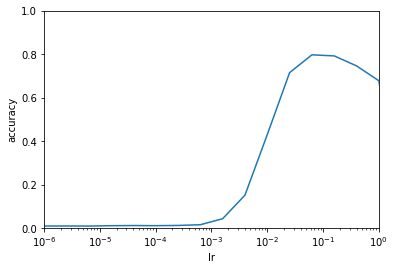

In [21]:
from matplotlib import pyplot as plt

plt.semilogx(his.history['lr'], his.history['accuracy'])
plt.axis([1e-6, 1, 0, 1])
plt.xlabel('lr')
plt.ylabel('accuracy')
plt.show()

In [6]:
ls -l

total 43809440
-rw-rw-r-- 1 bribeiro bribeiro    1302873 jul  3 11:45 20220629_InceptionV3_TL.ipynb
-rw-rw-r-- 1 bribeiro bribeiro     128227 jul  5 13:05 20220629_UFC101_Dense_CNNRNN2.ipynb
-rw-rw-r-- 1 bribeiro bribeiro      20112 jul  4 16:12 20220629_UFC101_DenseNet121_CNNRNN.ipynb
-rw-rw-r-- 1 bribeiro bribeiro     114057 jul  8 23:54 20220629_UFC101_DenseNet201_CNNRNN2.ipynb
-rw-rw-r-- 1 bribeiro bribeiro     107454 jul  2 17:12 20220629_UFC101_DenseNet_TF.ipynb
-rw-rw-r-- 1 bribeiro bribeiro      89905 jul  5 23:35 20220629_UFC101_EffB0_CNNRNN2.ipynb
-rw-rw-r-- 1 bribeiro bribeiro      70806 jul  5 23:28 20220629_UFC101_EffB4_CNNRNN2.ipynb
-rw-rw-r-- 1 bribeiro bribeiro      96083 jul  6 10:03 20220629_UFC101_EffB7_CNNRNN2.ipynb
-rw-rw-r-- 1 bribeiro bribeiro      54043 jul  5 11:49 20220629_UFC101_Inception_CNNRNN.ipynb
-rw-rw-r-- 1 bribeiro bribeiro      18387 jul  4 20:16 20220629_UFC101_ResNet101_CNNRNN.ipynb
-rw-rw-r-- 1 bribeiro bribeiro     119260 jul  8 23:54 20220629_UF

In [7]:
cd train

/media/datastorage/Phong/ufc101/train


In [8]:
ls -l

total 5066796
-rw-rw-r-- 1 bribeiro bribeiro  165124 out  1  2012 v_ApplyEyeMakeup_g08_c01.avi
-rw-rw-r-- 1 bribeiro bribeiro  162872 out  1  2012 v_ApplyEyeMakeup_g08_c02.avi
-rw-rw-r-- 1 bribeiro bribeiro  200528 out  1  2012 v_ApplyEyeMakeup_g08_c03.avi
-rw-rw-r-- 1 bribeiro bribeiro  282352 out  1  2012 v_ApplyEyeMakeup_g08_c04.avi
-rw-rw-r-- 1 bribeiro bribeiro  347292 out  1  2012 v_ApplyEyeMakeup_g08_c05.avi
-rw-rw-r-- 1 bribeiro bribeiro  346496 out  1  2012 v_ApplyEyeMakeup_g09_c01.avi
-rw-rw-r-- 1 bribeiro bribeiro  568884 out  1  2012 v_ApplyEyeMakeup_g09_c02.avi
-rw-rw-r-- 1 bribeiro bribeiro  366306 out  1  2012 v_ApplyEyeMakeup_g09_c03.avi
-rw-rw-r-- 1 bribeiro bribeiro  352910 out  1  2012 v_ApplyEyeMakeup_g09_c04.avi
-rw-rw-r-- 1 bribeiro bribeiro  333590 out  1  2012 v_ApplyEyeMakeup_g09_c05.avi
-rw-rw-r-- 1 bribeiro bribeiro  326330 out  1  2012 v_ApplyEyeMakeup_g09_c06.avi
-rw-rw-r-- 1 bribeiro bribeiro  451380 out  1  2012 v_ApplyEyeMakeup_g09_c07.avi
-rw-rw-r-- 1 b

-rw-rw-r-- 1 bribeiro bribeiro  749220 set  5  2012 v_BoxingSpeedBag_g11_c04.avi
-rw-rw-r-- 1 bribeiro bribeiro  654056 set  5  2012 v_BoxingSpeedBag_g11_c05.avi
-rw-rw-r-- 1 bribeiro bribeiro  444408 set  5  2012 v_BoxingSpeedBag_g11_c06.avi
-rw-rw-r-- 1 bribeiro bribeiro  666142 set  5  2012 v_BoxingSpeedBag_g12_c01.avi
-rw-rw-r-- 1 bribeiro bribeiro  650238 set  5  2012 v_BoxingSpeedBag_g12_c02.avi
-rw-rw-r-- 1 bribeiro bribeiro  672406 set  5  2012 v_BoxingSpeedBag_g12_c03.avi
-rw-rw-r-- 1 bribeiro bribeiro  543026 set  5  2012 v_BoxingSpeedBag_g12_c04.avi
-rw-rw-r-- 1 bribeiro bribeiro  440700 set  5  2012 v_BoxingSpeedBag_g12_c05.avi
-rw-rw-r-- 1 bribeiro bribeiro  669512 set  5  2012 v_BoxingSpeedBag_g13_c01.avi
-rw-rw-r-- 1 bribeiro bribeiro  571758 set  5  2012 v_BoxingSpeedBag_g13_c02.avi
-rw-rw-r-- 1 bribeiro bribeiro  471382 set  5  2012 v_BoxingSpeedBag_g13_c03.avi
-rw-rw-r-- 1 bribeiro bribeiro  510908 set  5  2012 v_BoxingSpeedBag_g13_c04.avi
-rw-rw-r-- 1 bribeiro bribei

-rw-rw-r-- 1 bribeiro bribeiro  369922 ago 26  2012 v_Shotput_g09_c05.avi
-rw-rw-r-- 1 bribeiro bribeiro  324724 ago 26  2012 v_Shotput_g09_c06.avi
-rw-rw-r-- 1 bribeiro bribeiro  327326 ago 26  2012 v_Shotput_g09_c07.avi
-rw-rw-r-- 1 bribeiro bribeiro  224528 ago 26  2012 v_Shotput_g10_c01.avi
-rw-rw-r-- 1 bribeiro bribeiro  326260 ago 26  2012 v_Shotput_g10_c02.avi
-rw-rw-r-- 1 bribeiro bribeiro  306908 ago 26  2012 v_Shotput_g10_c03.avi
-rw-rw-r-- 1 bribeiro bribeiro  370840 ago 26  2012 v_Shotput_g10_c04.avi
-rw-rw-r-- 1 bribeiro bribeiro  348732 ago 26  2012 v_Shotput_g10_c05.avi
-rw-rw-r-- 1 bribeiro bribeiro  305470 ago 26  2012 v_Shotput_g10_c06.avi
-rw-rw-r-- 1 bribeiro bribeiro  245248 ago 26  2012 v_Shotput_g11_c01.avi
-rw-rw-r-- 1 bribeiro bribeiro  206270 ago 26  2012 v_Shotput_g11_c02.avi
-rw-rw-r-- 1 bribeiro bribeiro  208936 ago 26  2012 v_Shotput_g11_c03.avi
-rw-rw-r-- 1 bribeiro bribeiro  218858 ago 26  2012 v_Shotput_g11_c04.avi
-rw-rw-r-- 1 bribeiro bribeiro  274116

In [14]:
def with_opencv(filename):
    import cv2
    video = cv2.VideoCapture(filename)

#     duration = video.get(cv2.CAP_PROP_POS_MSEC)
    frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
    
    fps = video.get(cv2.CAP_PROP_FPS) 
    duration = frame_count / fps

    return duration, fps, frame_count


print(with_opencv("v_ApplyEyeMakeup_g08_c01.avi"))
print(with_opencv("v_ApplyLipstick_g08_c01.avi"))
print(with_opencv("v_Archery_g18_c04.avi"))

(4.8, 25.0, 120.0)
(7.24, 25.0, 181.0)
(6.72, 25.0, 168.0)


In [29]:
print(videotimes)

[]


In [58]:
from pathlib import Path
path_of_the_directory = './'
print("Files and directories in a specified path:")
file = Path(path_of_the_directory ).glob('*')
videotimes=[]
videodurations=[]

# for i in file:
#     print(i)
filenames = [i.name for i in file]
# print(filenames)
# cv2.imread(file) for file in glob.glob("path/to/files/*.png")]

for j in tqdm(filenames):
#     cap = cv2.VideoCapture(i)
#     cap.release() #Release must be inside the outer loop    
#     print(j)
    durations,_,frame_counts = with_opencv(j)
#     print(frame_counts)
    videodurations.append(durations)
    videotimes.append(frame_counts)

Files and directories in a specified path:


100%|█████████████████████████████████████| 9537/9537 [00:08<00:00, 1098.97it/s]


In [59]:
print(min(videotimes))
print(max(videotimes))
print(min(videodurations))
print(max(videodurations))

29.0
1776.0
1.0677333333333334
71.04


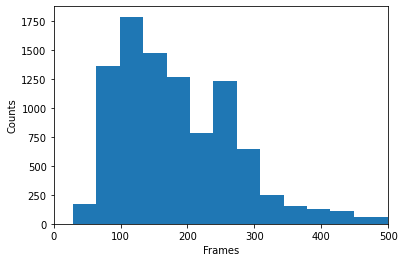

In [83]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

np.random.seed(42)
x = videotimes

plt.hist(x, density=False, bins=50)  # density=False would make counts
plt.xlim([0, 500])
plt.ylabel('Counts')
plt.xlabel('Frames');